In [23]:
%%time
%load_ext autoreload
from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "/Users/Akshay/Documents/tRNAShuffle/data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
#pCodon_WT = gr25_pCodon
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 22.6 s, sys: 1.34 s, total: 24 s
Wall time: 25.3 s


In [24]:
##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133


62


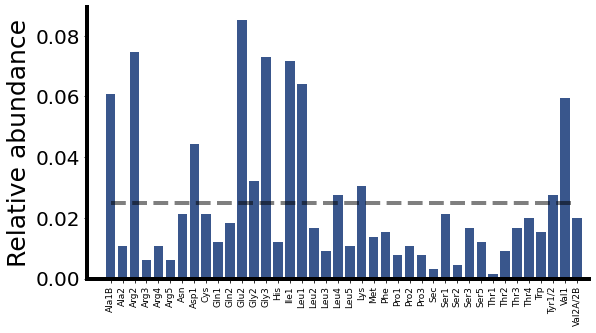

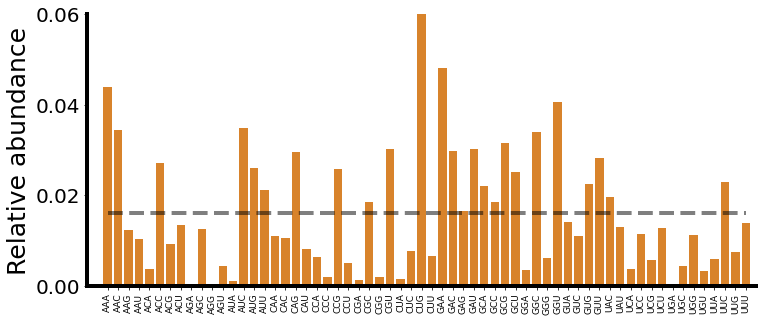

In [28]:
#plot frequency of tRNA vs. codon frequency plot for the new tRNA set vs old
tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met", "Phe", "Pro1", "Pro2", "Pro3", "Sec", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1/2", "Val1", "Val2A/2B"]

codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']
fig,ax0 = plt.subplots(figsize=(9,5))
ax0.bar(np.arange(40),gr25_ptRNA,color='#39568CFF',width=0.8)
ax0.plot(np.arange(40),[1/40]*40,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_tags,rotation='vertical')
ax0.set_xlim(-2,40)



pCodon_dict = dict(zip(codon_tags,pCodon_WT))
codon_tags_sorted = sorted(codon_tags)
pCodon_WT_sorted = [pCodon_dict[codon] for codon in codon_tags_sorted]

fig,ax = plt.subplots(figsize=(12,5))
ax.bar(np.arange(62),pCodon_WT_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_tags_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylim(0,0.06)
plt.yticks([0.0,0.02,0.04,0.06])

for ax in [ax0,ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylabel('Relative abundance',fontsize=25)

[192.10010863061967]
213.26762250324632 3.6096275011743257
[1.11019002]
z-score:  [5.86418235]
p-value [2.25675628e-09]
(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-04,
       4.5000e-04, 2.2500e-03, 9.3500e-03, 2.6200e-02, 5.1800e-02,
       8.7550e-02, 1.0965e-01, 9.9400e-02, 6.6300e-02, 3.2450e-02,
       1.1650e-02, 2.4500e-03, 3.5000e-04, 5.0000e-05, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]), array([190., 192., 194., 196., 198., 200., 202., 204., 206., 208., 210.,
       212., 214., 216., 218., 220., 222., 224., 226., 228., 230., 232.,
       234., 236., 238., 240., 242., 244., 246., 248., 250.]), <BarContainer object of 30 artists>)


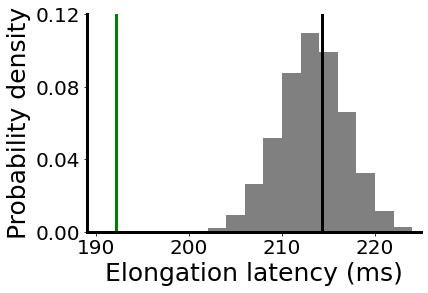

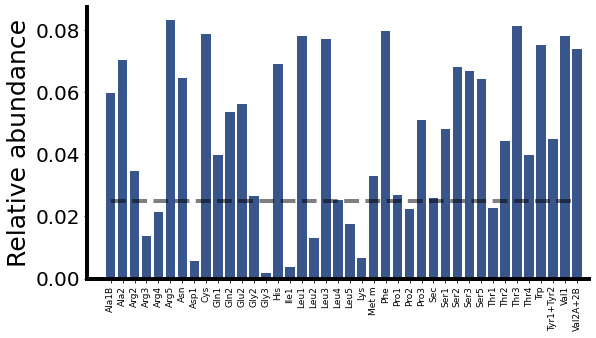

In [20]:
#Compute elongation latency for uniform tRNA with WT codon
ptRNA_uniform = np.ones(len(gr25_ptRNA))/sum(np.ones(len(gr25_ptRNA)))
elongt_WTtRNA_WTcodon, std = computeElongationLatency(gr25_ptRNA,pCodon_WT,ensmbl_latency_dict)
print(elongt_WTtRNA_WTcodon)
elongt_uniformtRNA_WTcodon, std = computeElongationLatency(ptRNA_uniform,pCodon_WT,ensmbl_latency_dict)

#### Plot tRNA shuffling
import matplotlib.pyplot as plt
import scipy.stats

elongt_list=np.load('./data/UniformRandomtRNA_WTCodonUsage_10ksample_elongt.npy')
ptRNA_list=np.load('./data/UniformRandomtRNA_WTCodonUsage_10ksample_ptRNA.npy')

fig,ax = plt.subplots(1,1)
hist=ax.hist(elongt_list,bins=30,range=(190,250),color='grey',density=True)
ax.plot([elongt_WTtRNA_WTcodon]*100,np.linspace(0,0.12,100),linewidth=3,color='green')
ax.plot([elongt_uniformtRNA_WTcodon]*100,np.linspace(0,0.12,100),linewidth=3,color='black')

print(np.mean(elongt_list), np.std(elongt_list))
print(np.mean(elongt_list)/elongt_WTtRNA_WTcodon)
print('z-score: ', (np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))
print('p-value', scipy.stats.norm.sf(abs((np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))))
for _,axes in enumerate([ax]):
    axes.spines['left'].set_linewidth(3)
    axes.spines['bottom'].set_linewidth(3)
    axes.spines['top'].set_linewidth(0)
    axes.spines['right'].set_linewidth(0)
    axes.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0,0.12)
    ax.set_xlim(189,225)
    ax.set_xlabel('Elongation latency (ms)',size=25)
    ax.set_ylabel('Probability density',size=25)
    ax.set_yticks(np.arange(0,0.121, 0.04))
print(hist)
fig.savefig('./Figures/1b.svg', dpi=300,bbox_inches='tight')

fig,ax0 = plt.subplots(figsize=(9,5))
ax0.bar(np.arange(40),ptRNA_list[0],color='#39568CFF',width=0.8)
ax0.plot(np.arange(40),[1/40]*40,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_tags,rotation='vertical')
ax0.set_xlim(-2,40)
ptRNA_random = ptRNA_list[0]

for ax in [ax0]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylabel('Relative abundance',fontsize=25)

199.95661350633017 2.0238369526054067
[1.03628492]
z-score:  [3.45945185]
p-value [0.00027064]


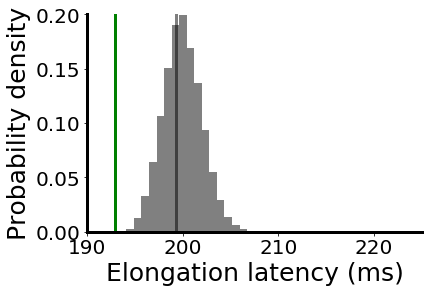

In [5]:
#Compute elongation latency for uniform codon with WT tRNA
pCodon_uniform = np.ones(len(gr25_pCodon))/sum(np.ones(len(gr25_pCodon)))

#List of synonymous codons based on codon label order
syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
              [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
              [50,51],[52,53],[58,59,60,61]]

for syn_codons in syn_codon_list:
    pCodon_uniform[syn_codons] = sum(pCodon_WT[syn_codons])/sum(pCodon_uniform[syn_codons])*pCodon_uniform[syn_codons]
pCodon_uniform = pCodon_uniform/np.sum(pCodon_uniform)

elongt_WTtRNA_uniformcodon, std = computeElongationLatency(gr25_ptRNA,pCodon_uniform,ensmbl_latency_dict)


#### Plot tRNA shuffling
import matplotlib.pyplot as plt
import scipy.stats

elongt_list=np.load('./data/WTtRNA_UniformRandomCodonUsage_10ksample_elongt.npy')

fig,ax = plt.subplots(1,1)
hist=ax.hist(elongt_list,20,color='grey',density=True)
ax.plot([elongt_WTtRNA_WTcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
ax.plot([elongt_WTtRNA_uniformcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='black',alpha=0.5)

print(np.mean(elongt_list), np.std(elongt_list))
print(np.mean(elongt_list)/elongt_WTtRNA_WTcodon)
print('z-score: ', (np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))
print('p-value', scipy.stats.norm.sf(abs((np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))))
for _,axes in enumerate([ax]):
    axes.spines['left'].set_linewidth(3)
    axes.spines['bottom'].set_linewidth(3)
    axes.spines['top'].set_linewidth(0)
    axes.spines['right'].set_linewidth(0)
    axes.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0,0.20)
    ax.set_xlim(190,225)
    ax.set_xlabel('Elongation latency (ms)',size=25)
    ax.set_ylabel('Probability density',size=25)

0.6 0.8999999999999999 1.3499999999999999 2.025 3.0375
[0.6, 0.901255230125523, 1.3430962343096233, 2.0259414225941423, 3.0]
[12.222021927512905, 14.495339272058759, 16.72443459453546, 19.021208671911605, 21.21473092769118]
[1.1860017399762968, 1.1537801413709239, 1.3122292838344887, 1.164464834624029]


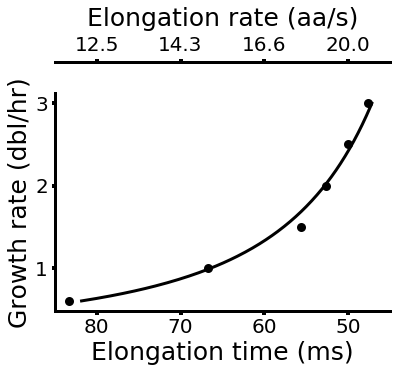

In [91]:
#phi_list= [0.6 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
# 9.5] 
#total_volfrac = [0.14090336 0.22457746 0.29675282 0.35000389 0.39256603 0.42856814
# 0.46030391 0.48914138 0.51594138 0.54126891 0.56550782 0.5889264
# 0.61171678 0.63401945 0.65593898 0.67755443 0.69892643 0.72010206
# 0.74111824]


fig, ax = plt.subplots(1,1,figsize = (6,4))

gr_list = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
elong_rate_list = np.array([12,15,18,19,20,21])
y_model,SS_err,_,_,_ = np.polyfit(np.log(gr_list),(elong_rate_list),1,full=True)
y_hat = y_model[0]*np.log(gr_list)+y_model[1]
x_sweep_i = np.linspace(min(gr_list),max(gr_list),240)
y_hat_sweep_i =  y_model[0]*np.log(x_sweep_i)+y_model[1]
ax.errorbar(1000/elong_rate_list,gr_list,[0,0,0,0,0,0],marker='o',markersize=7,markeredgewidth=2,zorder=1,linewidth=0,color='black')
ax.plot(1000/np.array(y_hat_sweep_i),x_sweep_i,marker='o',markersize=0,markevery=199,linewidth=3,color='black')
ax.set_xlim(ax.get_xlim()[::-1])


print(0.6,0.6*1.5,0.6*1.5**2,0.6*1.5**3,0.6*1.5**4)
x = [x_sweep_i[0],x_sweep_i[30],x_sweep_i[74],x_sweep_i[142],x_sweep_i[239]]
y=[y_hat_sweep_i[0],y_hat_sweep_i[30],y_hat_sweep_i[74],y_hat_sweep_i[142],y_hat_sweep_i[239]]
ydivx=[y_hat_sweep_i[30]/y_hat_sweep_i[0],y_hat_sweep_i[74]/y_hat_sweep_i[30],y_hat_sweep_i[142]/y_hat_sweep_i[30],y_hat_sweep_i[239]/y_hat_sweep_i[115]]
print(x)
print(y)
print(ydivx)

#gr_list_extended = [0.6,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0]
#y_hat = y_model[0]*np.log(gr_list)+y_model[1]
#x_sweep_i = np.linspace(min(gr_list_extended),max(gr_list_extended),640)
#y_hat_sweep_i =  y_model[0]*np.log(x_sweep_i)+y_model[1]
#ax.errorbar(gr_list,[1000/12,1000/15,1000/18,1000/19,1000/20,1000/21],[0,0,0,0,0,0],marker='o',markersize=7,markeredgewidth=2,zorder=1,linewidth=0,color='black')
#ax.plot(x_sweep_i,1000/np.array(y_hat_sweep_i),marker='o',markersize=0,markevery=199,linewidth=3,color='black',linestyle='dashed')

ax.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax.set_xlim(0.4,4.2)
ax.set_xlim(85,45)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_ylabel('Growth rate (dbl/hr)',size=25,color='black')
ax.set_xlabel('Elongation time (ms)',size=25,color='black')


ax2 = ax.twiny()
ax2.set_xlim(85,45)
ax2.tick_params(axis='both', which='major',width=4, labelsize=20)
ax2.set_xlabel('Elongation rate (aa/s)',size=25,color='black',labelpad=10)
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['25','20.0','16.6','14.3','12.5']
ax2.set_xticklabels(labels)
ax2.spines['right'].set_linewidth(0)

plt.gca().spines['top'].set_position(('data',3.5))
ax2.spines['top'].set_linewidth(3)


0.6 0.8999999999999999 1.3499999999999999 2.025 3.0375
[0.6, 0.901255230125523, 1.3430962343096233, 2.0259414225941423, 3.0]
[12.222021927512905, 14.495339272058759, 16.72443459453546, 19.021208671911605, 21.21473092769118]
[1.1860017399762968, 1.1537801413709239, 1.3122292838344887, 1.164464834624029]


Text(0.5, 0, 'Elongation time (ms)')

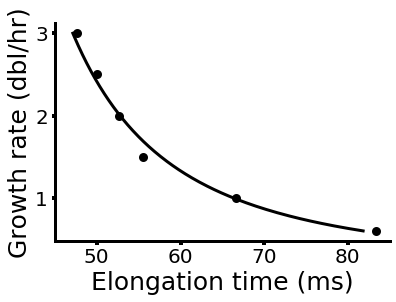

In [108]:
fig, ax = plt.subplots(1,1,figsize = (6,4))

gr_list = np.array([0.6,1.0,1.5,2.0,2.5,3.0])
elong_rate_list = np.array([12,15,18,19,20,21])
y_model,SS_err,_,_,_ = np.polyfit(np.log(gr_list),(elong_rate_list),1,full=True)
y_hat = y_model[0]*np.log(gr_list)+y_model[1]
x_sweep_i = np.linspace(min(gr_list),max(gr_list),240)
y_hat_sweep_i =  y_model[0]*np.log(x_sweep_i)+y_model[1]
ax.errorbar(1000/elong_rate_list,gr_list,[0,0,0,0,0,0],marker='o',markersize=7,markeredgewidth=2,zorder=1,linewidth=0,color='black')
ax.plot(1000/np.array(y_hat_sweep_i),x_sweep_i,marker='o',markersize=0,markevery=199,linewidth=3,color='black')


print(0.6,0.6*1.5,0.6*1.5**2,0.6*1.5**3,0.6*1.5**4)
x = [x_sweep_i[0],x_sweep_i[30],x_sweep_i[74],x_sweep_i[142],x_sweep_i[239]]
y=[y_hat_sweep_i[0],y_hat_sweep_i[30],y_hat_sweep_i[74],y_hat_sweep_i[142],y_hat_sweep_i[239]]
ydivx=[y_hat_sweep_i[30]/y_hat_sweep_i[0],y_hat_sweep_i[74]/y_hat_sweep_i[30],y_hat_sweep_i[142]/y_hat_sweep_i[30],y_hat_sweep_i[239]/y_hat_sweep_i[115]]
print(x)
print(y)
print(ydivx)

ax.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax.set_xlim(0.4,4.2)
ax.set_xlim(45,85)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_ylabel('Growth rate (dbl/hr)',size=25,color='black')
ax.set_xlabel('Elongation time (ms)',size=25,color='black')


#ax2 = ax.twiny()
#ax2.set_xlim(45,85)
#ax2.tick_params(axis='both', which='major',width=4, labelsize=20)
#ax2.set_xlabel('Elongation rate (aa/s)',size=25,color='black',labelpad=10)
#labels = [item.get_text() for item in ax2.get_xticklabels()]
#labels = ['25','20.0','16.6','14.3','12.5']
#ax2.set_xticklabels(labels)
#ax2.spines['right'].set_linewidth(0)

#plt.gca().spines['top'].set_position(('data',3.5))
#ax2.spines['top'].set_linewidth(3)


In [ ]:

print(x_sweep_i[240])
print(x_sweep_i[138])
print(x_sweep_i[240]/x_sweep_i[138])
(1000/y_hat_sweep_i[240])/(1000/y_hat_sweep_i[138])


/var/folders/ht/q05lxg2n6vq4wbnbcfkt9kmc0000gn/T/ipykernel_53147/1769095586.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


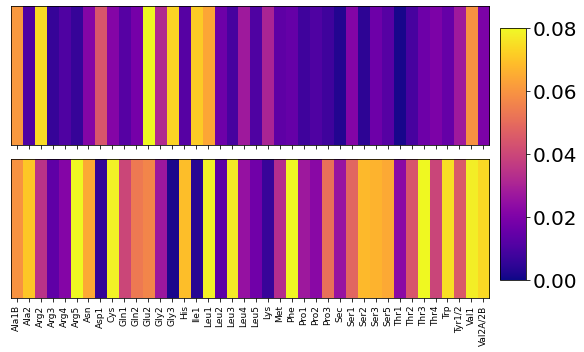

In [15]:

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True,figsize=(7,5))

x = np.arange(0,40)
y = np.array(gr25_ptRNA)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])
ax.tick_params(axis='x', which='major', labelsize=9)

x = np.arange(0,40)
y = np.array(ptRNA_random)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax2.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax2.set_yticks([])
ax2.set_xlim(extent[0], extent[1])
ax2.tick_params(axis='x', which='major', labelsize=9)

plt.xticks(range(len(tRNA_tags)), tRNA_tags ,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.21, 0.05, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()    

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133


/var/folders/ht/q05lxg2n6vq4wbnbcfkt9kmc0000gn/T/ipykernel_53147/1944745607.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


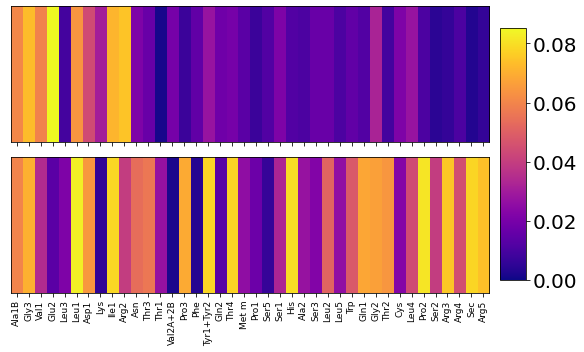

In [22]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
ptRNA_sorted_WT = ptRNA_sorted
tRNA_sorted_WT = tRNA_sorted

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True,figsize=(7,5))
x = np.arange(0,40)
y = np.array(ptRNA_sorted_WT)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.0852)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])
ax.tick_params(axis='x', which='major', labelsize=9)

x = np.arange(0,40)
y = np.array(ptRNA_random)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax2.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.0852)
ax2.set_yticks([])
ax2.set_xlim(extent[0], extent[1])
ax2.tick_params(axis='x', which='major', labelsize=9)

plt.xticks(range(len(tRNA_tags)), tRNA_sorted ,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.21, 0.05, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()    

In [16]:
gr25_ptRNA

array([0.0608828 , 0.01065449, 0.07458143, 0.00608828, 0.01065449,
       0.00608828, 0.02130898, 0.04414003, 0.02130898, 0.01217656,
       0.01826484, 0.08523592, 0.03196347, 0.07305936, 0.01217656,
       0.07153729, 0.06392694, 0.01674277, 0.00913242, 0.02739726,
       0.01065449, 0.0304414 , 0.01369863, 0.0152207 , 0.00761035,
       0.01065449, 0.00761035, 0.00304414, 0.02130898, 0.00456621,
       0.01674277, 0.01217656, 0.00152207, 0.00913242, 0.01674277,
       0.01978691, 0.0152207 , 0.02739726, 0.05936073, 0.01978691])